In [1]:
import os
from src.config import directories
COMPOSITIONAL_NETS_PATH = directories['CompositionalNets']
CODE_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'Code')
DATA_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'data')
MODELS_PATH = os.path.join(COMPOSITIONAL_NETS_PATH, 'models')

import sys
compositional_nets_path = directories['CompositionalNets']
if compositional_nets_path not in sys.path:
    sys.path.append(compositional_nets_path)

In [3]:
import pdb
from PIL import Image
from glob import glob
import tarfile

import cv2
import pandas as pd
import numpy as np
import tqdm
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import transforms

from Code.config import categories, categories_train, dataset, data_path, device_ids, mix_model_path, dict_dir, layer, vMF_kappa, model_save_dir, compnet_type, backbone_type, num_mixtures
from Code.config import config as cfg
from Code.model import Net
from Code.helpers import Imgset, imgLoader, getVmfKernels, getCompositionModel, update_clutter_model
from Code.eval_occlusion_localization import visualize_response_map

In [3]:
if device_ids: print("GPU Available")
else: print("CPU")

GPU Available


# Sanity Check (Original Demo)

In [4]:
###################
# Test parameters #
###################
likely = 0.6  # occlusion likelihood
bool_load_pretrained_model = True
bool_mixture_model_bg = False 	# use maximal mixture model or sum of all mixture models, not so important
bool_multi_stage_model = False 	# this is an old setup


Image ./demo/17029_0_val2017.jpg classified as car
Occlusion map written to: demo/demo_predclass_car_and_occluder_map.jpg

Image ./demo/81819_0_train2017.jpg classified as bus
Occlusion map written to: demo/demo_predclass_bus_and_occluder_map.jpg

Image ./demo/487059_4_train2017.jpg classified as motorbike
Occlusion map written to: demo/demo_predclass_motorbike_and_occluder_map.jpg


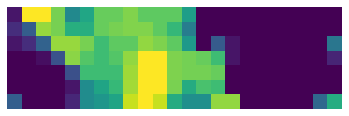

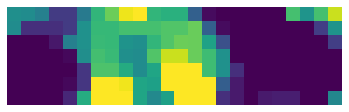

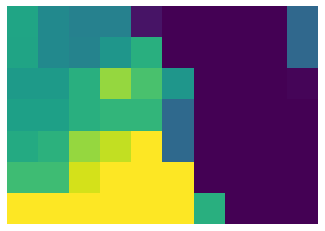

In [6]:
occ_likely = []
for i in range(len(categories_train)):
    occ_likely.append(0.6)
############################
# Get CompositionalNet Init
############################
# get pool5 feature extractor
extractor = models.vgg16(pretrained=True).features
if device_ids: 
    extractor.cuda(device_ids[0]).eval()
weights = getVmfKernels(dict_dir, device_ids)

mix_model_path = mix_model_path + '/'
mix_models = getCompositionModel(device_ids, mix_model_path, layer, 
                                 categories_train,compnet_type=compnet_type,
                                 num_mixtures=num_mixtures)
net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
          bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type, 
          num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD)
if device_ids:
    net = net.cuda(device_ids[0])
pretrained_model = model_save_dir+'vgg_pool5_p3d+/best.pth'
if device_ids:
    load_dict = torch.load(pretrained_model, map_location='cuda:{}'.format(device_ids[0]))
else:
    load_dict = torch.load(pretrained_model, map_location='cpu')
net.load_state_dict(load_dict['state_dict'])
if device_ids:
    net = net.cuda(device_ids[0])
updated_clutter = update_clutter_model(net,device_ids)
net.clutter_model = updated_clutter

########################################################
# Classify image and extract occluder locations
########################################################

test_imgs = []
demo_path = os.path.join(COMPOSITIONAL_NETS_PATH, 'demo')
test_imgs.append(os.path.join(demo_path, '17029_0_val2017.jpg'))
test_imgs.append(os.path.join(demo_path, '81819_0_train2017.jpg'))
test_imgs.append(os.path.join(demo_path, '487059_4_train2017.jpg'))

test_imgset = Imgset(test_imgs, [[''],[''],['']], [5,4,8], imgLoader, bool_square_images=False)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        #load data
        input, mask, label = data
        if device_ids:
            input = input.cuda(device_ids[0])
        c_label = label.numpy()
        img_name = test_loader.dataset.images[i]
        #classify
        output, *_ = net(input)
        out = output.cpu().numpy().argmax(-1)[0]
        pred_class = categories_train[out]
        print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
        score, occ_maps, part_scores = net.get_occlusion(input, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0, show=True)
        # concatenate original image and occluder map
        img_orig = cv2.imread(img_name)
        faco = img_orig.shape[0] / occ_img.shape[0]
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        out_name = 'demo/{}_predclass_{}_and_occluder_map.jpg'.format(img_name.split('/')[1].split('.')[0],pred_class)
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        cv2.imwrite(out_name, canvas)
        print('Occlusion map written to: {}'.format(out_name))

# Experiments

For training, we'd like to see how well the model can perform with different instances of training: 
1. on __only__ healty images 
2. on a 50/50 mix of healthy and sick images.

In [4]:
from Code.config import device_ids, mix_model_path, categories, categories_train, dict_dir, dataset, data_path, layer, vc_num, model_save_dir, compnet_type,backbone_type, vMF_kappa,num_mixtures
from Code.train import train
from Code.model import Net
from Code.helpers import getImg, Imgset, imgLoader, save_checkpoint,getCompositionModel,getVmfKernels, update_clutter_model
from Code.config import config as cfg
from torch.utils.data import DataLoader
from Code.losses import ClusterLoss
from Code.model import resnet_feature_extractor
import torchvision.models as models
from torch import nn
import time
from PIL import Image

IndexError: list index out of range

In [8]:
categories = {0: 'No Finding', 1: 'Mass'}

## Data

In [9]:
# Need to keep tar files open, otherwise we can't access the images later
tar_no_finding = tarfile.open(os.path.join(DATA_PATH, "No Finding.tar.gz"), "r:gz")
images_no_finding, names_no_finding = [], []
for member in tar_no_finding.getmembers():
    images_no_finding.append(Image.open(tar_no_finding.extractfile(member)))
    names_no_finding.append(os.path.basename(member.name))
    
tar_mass = tarfile.open(os.path.join(DATA_PATH, "Mass.tar.gz"), "r:gz")
images_mass, names_mass = [], []
for member in tar_mass.getmembers():
    images_mass.append(Image.open(tar_mass.extractfile(member)))
    names_mass.append(os.path.basename(member.name))

In [10]:
bbox_entries = pd.read_csv(os.path.join(DATA_PATH, 'BBox_List_2017.csv'))
data_entries = pd.read_csv(os.path.join(DATA_PATH, 'Data_Entry_2017_v2020.csv'))

In [2]:
def img_loader(input_image, mask_path, bool_resize_images=True, bool_square_images=True):
    # CompositionalNet takes RGB images as input
    input_image = Image.fromarray(input_image)
    if input_image.mode != 'RGB': input_image = input_image.convert('RGB')
    
    if bool_resize_images:
        if bool_square_images:
            input_image.resize((224,224),Image.ANTIALIAS)
        else:
            sz=input_image.size
            min_size = np.min(sz)
            if min_size!=224:
                input_image = input_image.resize((np.asarray(sz) * (224 / min_size)).astype(int),
                                                 Image.ANTIALIAS)
                
    preprocess =  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = preprocess(input_image)

    if mask_path[0]:
        mask1 = cv2.imread(mask_path[0])[:, :, 0]
        mask1 = myresize(mask1, 224, 'short')
        try:
            mask2 = cv2.imread(mask_path[1])[:, :, 0]
            mask2 = mask2[:mask1.shape[0], :mask1.shape[1]]
        except:
            mask = mask1
        try:
            mask = ((mask1 == 255) * (mask2 == 255)).astype(np.float)
        except:
            mask = mask1
    else:
        mask = np.ones((img.shape[0], img.shape[1])) * 255.0

    mask = torch.from_numpy(mask)
    return img, mask

## Zero Occlusion in Training

### Training

In [13]:
#---------------------
# Training Parameters
#---------------------
alpha = 3  # vc-loss
beta = 3 # mix loss
likely = 0.6 # occlusion likelihood
lr = 1e-2 # learning rate
batch_size = 1 # these are pseudo batches as the aspect ratio of images for CompNets is not square
# Training setup
vc_flag = True # train the vMF kernels
mix_flag = True # train mixture components
ncoord_it = 1 #number of epochs to train

bool_mixture_model_bg = False #True: use a mixture of background models per pixel, False: use one bg model for whole image
bool_load_pretrained_model = True
bool_train_with_occluders = False

if bool_train_with_occluders:
    occ_levels_train = ['ZERO', 'ONE', 'FIVE', 'NINE']
else:
    occ_levels_train = ['ZERO']

model_save_dir = model_save_dir + '/'
out_dir = model_save_dir + 'train_{}_a{}_b{}_vc{}_mix{}_occlikely{}_vc{}_lr_{}_{}_pretrained{}_epochs_{}_occ{}_backbone{}/'.format(
    layer, alpha,beta, vc_flag, mix_flag, likely, vc_num, 
    lr, dataset, bool_load_pretrained_model,ncoord_it,bool_train_with_occluders,backbone_type)

In [3]:
if backbone_type=='vgg':
    if layer=='pool4':
        extractor = models.vgg16(pretrained=True).features[0:24]
    else:
        extractor = models.vgg16(pretrained=True).features
elif backbone_type=='resnet50' or backbone_type=='resnext':
    extractor = resnet_feature_extractor(backbone_type, layer)

if device_ids:
    extractor.cuda(device_ids[0]).eval()
else:
    extractor.eval()
weights = getVmfKernels(dict_dir, device_ids)

if bool_load_pretrained_model:
    pretrained_file = model_save_dir+'vgg_pool5_p3d+/best.pth'
else:
    pretrained_file = ''

occ_likely = []
for i in range(len(categories_train)):
    # setting the same occlusion likelihood for all classes
    occ_likely.append(likely)

# load the CompNet initialized with ML and spectral clustering
mix_models = getCompositionModel(device_ids,mix_model_path,layer,categories_train,compnet_type=compnet_type)
net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
          bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
          num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD)

if bool_load_pretrained_model:
    if device_ids:
        net.load_state_dict(torch.load(pretrained_file, 
                                       map_location='cuda:{}'.format(device_ids[0]))['state_dict'])
    else:
        net.load_state_dict(torch.load(pretrained_file, 
                               map_location='cpu')['state_dict'])
if device_ids:
    net = net.cuda(device_ids[0])

train_imgs=[]
train_masks = []
train_labels = []
val_imgs = []
val_labels = []
val_masks=[]

# get training and validation images
for occ_level in occ_levels_train:
    if occ_level == 'ZERO':
        occ_types = ['']
        train_fac=0.9
    else:
        occ_types = ['_white', '_noise', '_texture', '']
        train_fac=0.1

    for occ_type in occ_types:
        
#         images, labels, masks = images_no_finding, ['No Finding'], [[]]
        # Test with two images for training. "No Finding" label encoded as 0
#         images = images_no_finding[0:2]
        images = images_no_finding[:100]
        labels = [0] * len(images)
        masks = [['']] * len(images)
        
print('Total imgs for training ' + str(len(images)))
train_imgset = Imgset(images, masks, labels, img_loader, bool_square_images=True)

NameError: name 'backbone_type' is not defined

In [16]:
model=net 
train_data=train_imgset
val_data=None
epochs=ncoord_it
batch_size=batch_size
learning_rate=lr
savedir=out_dir
alpha=alpha
beta=beta
vc_flag=vc_flag
mix_flag=mix_flag

best_check = {
    'epoch': 0,
    'best': 0,
    'val_acc': 0
}
out_file_name = savedir + 'result.txt'
total_train = len(train_data)
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
# val_loaders=[]

# for i in range(len(val_data)):
#     val_loader = DataLoader(dataset=val_data[i], batch_size=1, shuffle=True)
#     val_loaders.append(val_loader)

# we observed that training the backbone does not make a very big difference but not training saves a lot of memory
# if the backbone should be trained, then only with very small learning rate e.g. 1e-7
for param in model.backbone.parameters():
    param.requires_grad = False

if not vc_flag:
    model.conv1o1.weight.requires_grad = False
else:
    model.conv1o1.weight.requires_grad = True

if not mix_flag:
    model.mix_model.requires_grad = False
else:
    model.mix_model.requires_grad = True

classification_loss = nn.CrossEntropyLoss()
cluster_loss = ClusterLoss()

optimizer = torch.optim.Adagrad(params=filter(lambda param: param.requires_grad, 
                                              model.parameters()), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

print('Training')

for epoch in range(epochs):
    out_file = open(out_file_name, 'a')
    train_loss = 0.0
    correct = 0
    start = time.time()
    model.train()
    model.backbone.eval()
    
    for index, data in enumerate(train_loader):
        if index % 500 == 0 and index != 0:
            end = time.time()
            print('Epoch{}: {}/{}, Acc: {}, Loss: {} Time:{}'.format(epoch + 1, index, 
                                                                     total_train, 
                                                                     correct.cpu().item() / index, train_loss.cpu().item() / index, 
                                                                     (end-start)))
            start = time.time()

        input, _, label = data
        
        if device_ids:
            input = input.cuda(device_ids[0])
            label = label.cuda(device_ids[0])

        output, vgg_feat, like = model(input)

        out = output.argmax(1)
#         pdb.set_trace()
        correct += torch.sum(out == label)
        class_loss = classification_loss(output, label) / output.shape[0]

        loss = class_loss
        if alpha != 0:
            clust_loss = cluster_loss(vgg_feat, model.conv1o1.weight) / output.shape[0]
            loss += alpha * clust_loss

        if beta!=0:
            mix_loss = like[0,label[0]]
            loss += -beta *mix_loss

        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()

        # pseudo batches
        if np.mod(index,batch_size)==0:# and index!=0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.detach() * input.shape[0]

    updated_clutter = update_clutter_model(model,device_ids)
    model.clutter_model = updated_clutter
    scheduler.step()
    train_acc = correct.cpu().item() / total_train
    train_loss = train_loss.cpu().item() / total_train
    out_str = 'Epochs: [{}/{}], Train Acc:{}, Train Loss:{}'.format(epoch + 1, epochs, train_acc, train_loss)
    print(out_str)
#     out_file.write(out_str)

Training
Epochs: [1/1], Train Acc:0.58, Train Loss:-44.2471044921875


In [17]:
torch.save(model.state_dict(), 'models/4.pth')

### Testing

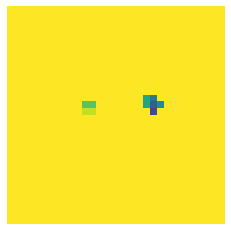

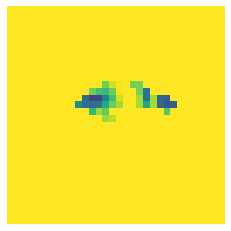

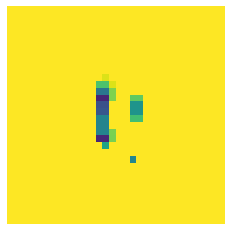

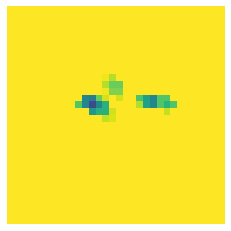

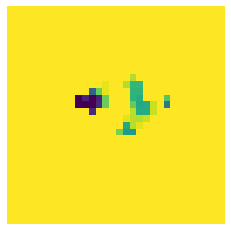

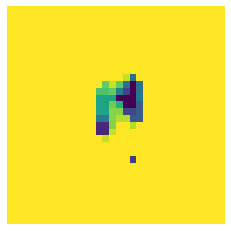

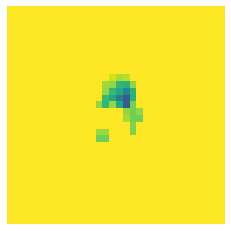

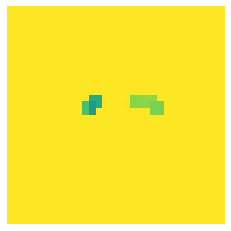

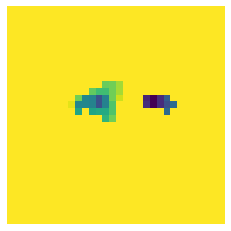

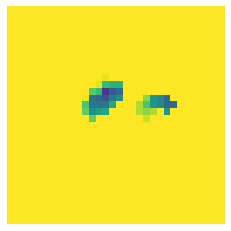

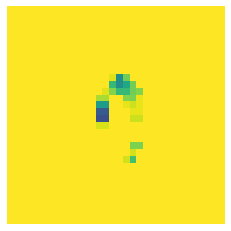

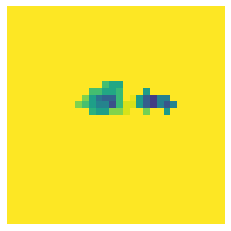

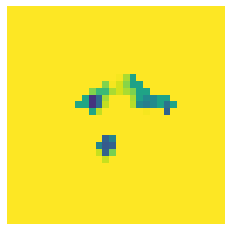

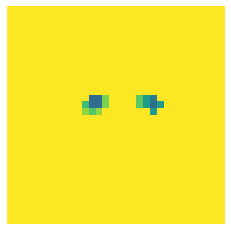

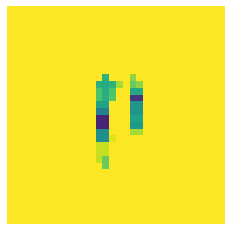

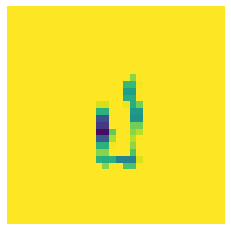

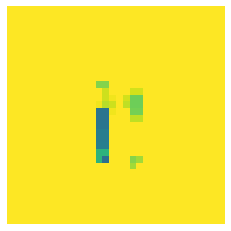

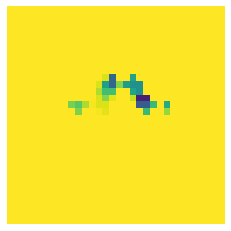

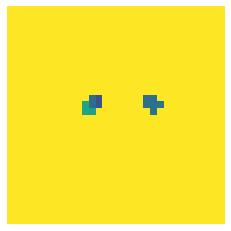

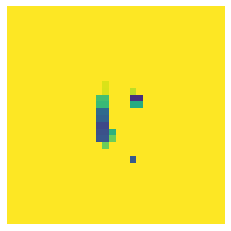

In [18]:
# test_imgset = Imgset(images_mass[:3], [[''],[''],['']], [1, 1, 1], img_loader, bool_square_images=True)
test_imgset = Imgset(images_mass[:20], [['']] * len(images_mass), [1] * len(images_mass), 
                     img_loader, bool_square_images=True)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, data in tqdm_notebook(enumerate(test_loader)):
        #load data
        img_orig = images_mass[i].convert('RGB')
        input_img, mask, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
        c_label = label.numpy()
        img_name = os.path.splitext(names_mass[i])[0]
        #classify
        output, *_ = model(input_img)
        out = output.cpu().numpy().argmax(-1)[0]
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
        score, occ_maps, part_scores = net.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0, show=True)
        # concatenate original image and occluder map
        img_orig = np.array(img_orig)
        faco = img_orig.shape[0] / occ_img.shape[0]
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
        out_name = f'results/4/{img_name}_with_occlusion_map.png'
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
        cv2.imwrite(out_name, canvas)

## With Occlusion in Training

In [93]:
#---------------------
# Training Parameters
#---------------------
alpha = 3  # vc-loss
beta = 3 # mix loss
likely = 0.6 # occlusion likelihood
lr = 1e-2 # learning rate
batch_size = 1 # these are pseudo batches as the aspect ratio of images for CompNets is not square
# Training setup
vc_flag = True # train the vMF kernels
mix_flag = True # train mixture components
ncoord_it = 25 #number of epochs to train

bool_mixture_model_bg = False #True: use a mixture of background models per pixel, False: use one bg model for whole image
bool_load_pretrained_model = False
bool_train_with_occluders = True

if bool_train_with_occluders:
    occ_levels_train = ['ONE']

model_save_dir = 'models/'
out_dir = model_save_dir + 'with_occlusion'

In [94]:
X_train_mass, X_test_mass, y_train_mass, y_test_mass = train_test_split(images_mass, 
                                                         [1] * len(images_mass), test_size=0.5)

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(images_no_finding[:len(images_mass)], 
                                                         [0] * len(images_mass), test_size=0.5)

In [95]:
if backbone_type=='vgg':
    if layer=='pool4':
        extractor = models.vgg16(pretrained=True).features[0:24]
    else:
        extractor = models.vgg16(pretrained=True).features
elif backbone_type=='resnet50' or backbone_type=='resnext':
    extractor = resnet_feature_extractor(backbone_type, layer)

if device_ids:
    extractor.cuda(device_ids[0]).eval()
else:
    extractor.eval()
weights = getVmfKernels(dict_dir, device_ids)

if bool_load_pretrained_model:
    pretrained_file = 'PATH TO .PTH FILE HERE'
else:
    pretrained_file = ''

occ_likely = []
for i in range(len(categories_train)):
    # setting the same occlusion likelihood for all classes
    occ_likely.append(likely)

# load the CompNet initialized with ML and spectral clustering
mix_models = getCompositionModel(device_ids,mix_model_path,layer,categories_train,compnet_type=compnet_type)
net = Net(extractor, weights, vMF_kappa, occ_likely, mix_models, 
          bool_mixture_bg=bool_mixture_model_bg,compnet_type=compnet_type,
          num_mixtures=num_mixtures, vc_thresholds=cfg.MODEL.VC_THRESHOLD)

if bool_load_pretrained_model:
    if device_ids:
        net.load_state_dict(torch.load(pretrained_file, 
                                       map_location='cuda:{}'.format(device_ids[0]))['state_dict'])
    else:
        net.load_state_dict(torch.load(pretrained_file, 
                               map_location='cpu')['state_dict'])
if device_ids:
    net = net.cuda(device_ids[0])

train_imgs=[]
train_masks = []
train_labels = []
val_imgs = []
val_labels = []
val_masks=[]

X_train_mass, X_test_mass, y_train_mass, y_test_mass = train_test_split(images_mass, 
                                                         [1] * len(images_mass), test_size=0.5)

X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(images_no_finding[:len(images_mass)], 
                                                         [0] * len(images_mass), test_size=0.5)

# get training and validation images
for occ_level in occ_levels_train:
    if occ_level == 'ZERO':
        occ_types = ['']
        train_fac=0.9
    else:
        occ_types = ['_mass']
        train_fac=0.1

    for occ_type in occ_types:
        
        train_imgs.extend(X_train_mass)
        train_imgs.extend(X_train_nf)
        train_labels.extend(y_train_mass)
        train_labels.extend(y_train_nf)
        train_masks = [['']] * len(train_imgs)
        
print('Total imgs for training ' + str(len(train_imgs)))
train_imgset = Imgset(train_imgs, train_masks, train_labels, img_loader, bool_square_images=True)

Total imgs for training 250


In [96]:
model=net 
train_data=train_imgset
val_data=None
epochs=ncoord_it
batch_size=batch_size
learning_rate=lr
savedir=out_dir
alpha=alpha
beta=beta
vc_flag=vc_flag
mix_flag=mix_flag

best_check = {
    'epoch': 0,
    'best': 0,
    'val_acc': 0
}
out_file_name = savedir + 'result.txt'
total_train = len(train_data)
train_loader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
# val_loaders=[]

# for i in range(len(val_data)):
#     val_loader = DataLoader(dataset=val_data[i], batch_size=1, shuffle=True)
#     val_loaders.append(val_loader)

# we observed that training the backbone does not make a very big difference but not training saves a lot of memory
# if the backbone should be trained, then only with very small learning rate e.g. 1e-7
for param in model.backbone.parameters():
    param.requires_grad = False

if not vc_flag:
    model.conv1o1.weight.requires_grad = False
else:
    model.conv1o1.weight.requires_grad = True

if not mix_flag:
    model.mix_model.requires_grad = False
else:
    model.mix_model.requires_grad = True

classification_loss = nn.CrossEntropyLoss()
cluster_loss = ClusterLoss()

optimizer = torch.optim.Adagrad(params=filter(lambda param: param.requires_grad, 
                                              model.parameters()), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)

print('Training')

for epoch in range(epochs):
    out_file = open(out_file_name, 'a')
    train_loss = 0.0
    correct = 0
    start = time.time()
    model.train()
    model.backbone.eval()
    
    for index, data in enumerate(train_loader):
        if index % 500 == 0 and index != 0:
            end = time.time()
            print('Epoch{}: {}/{}, Acc: {}, Loss: {} Time:{}'.format(epoch + 1, index, 
                                                                     total_train, 
                                                                     correct.cpu().item() / index, train_loss.cpu().item() / index, 
                                                                     (end-start)))
            start = time.time()

        input, _, label = data
        
        if device_ids:
            input = input.cuda(device_ids[0])
            label = label.cuda(device_ids[0])

        output, vgg_feat, like = model(input)

        out = output.argmax(1)
#         pdb.set_trace()
        correct += torch.sum(out == label)
        class_loss = classification_loss(output, label) / output.shape[0]

        loss = class_loss
        if alpha != 0:
            clust_loss = cluster_loss(vgg_feat, model.conv1o1.weight) / output.shape[0]
            loss += alpha * clust_loss

        if beta!=0:
            mix_loss = like[0,label[0]]
            loss += -beta *mix_loss

        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()

        # pseudo batches
        if np.mod(index,batch_size)==0:# and index!=0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.detach() * input.shape[0]

    updated_clutter = update_clutter_model(model,device_ids)
    model.clutter_model = updated_clutter
    scheduler.step()
    train_acc = correct.cpu().item() / total_train
    train_loss = train_loss.cpu().item() / total_train
    out_str = 'Epochs: [{}/{}], Train Acc:{}, Train Loss:{}'.format(epoch + 1, epochs, train_acc, train_loss)
    print(out_str)
    out_file.write(out_str)

Training
Epochs: [1/25], Train Acc:0.472, Train Loss:-45.9916796875
Epochs: [2/25], Train Acc:0.5, Train Loss:-49.324484375
Epochs: [3/25], Train Acc:0.516, Train Loss:-49.9339765625
Epochs: [4/25], Train Acc:0.52, Train Loss:-50.25253515625
Epochs: [5/25], Train Acc:0.524, Train Loss:-50.4555625
Epochs: [6/25], Train Acc:0.548, Train Loss:-50.59443359375
Epochs: [7/25], Train Acc:0.56, Train Loss:-50.70876953125
Epochs: [8/25], Train Acc:0.616, Train Loss:-50.80769921875
Epochs: [9/25], Train Acc:0.616, Train Loss:-50.87090625
Epochs: [10/25], Train Acc:0.632, Train Loss:-50.91682421875
Epochs: [11/25], Train Acc:0.648, Train Loss:-50.95041015625
Epochs: [12/25], Train Acc:0.664, Train Loss:-50.9792890625
Epochs: [13/25], Train Acc:0.68, Train Loss:-51.0041484375
Epochs: [14/25], Train Acc:0.696, Train Loss:-51.0258671875
Epochs: [15/25], Train Acc:0.688, Train Loss:-51.045359375
Epochs: [16/25], Train Acc:0.692, Train Loss:-51.06348828125
Epochs: [17/25], Train Acc:0.684, Train Loss:

Predicted as: No Finding
Predicted as: No Finding
Predicted as: No Finding
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding
Predicted as: Mass
Predicted as: Mass
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding
Predicted as: No Finding
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding


./Code/eval_occlusion_localization.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1)


Predicted as: No Finding
Predicted as: Mass
Predicted as: No Finding
Predicted as: No Finding


KeyboardInterrupt: 

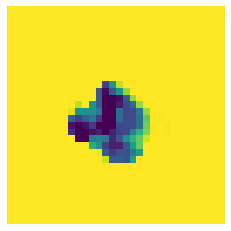

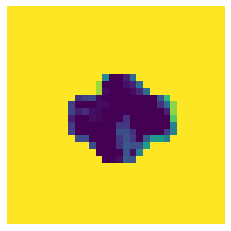

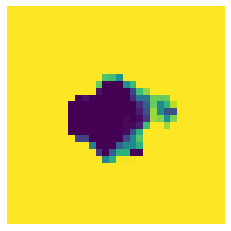

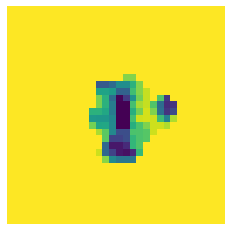

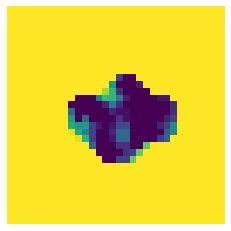

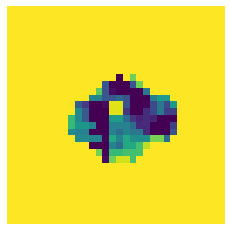

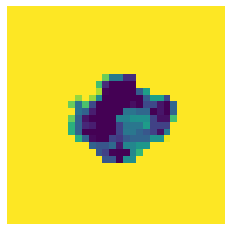

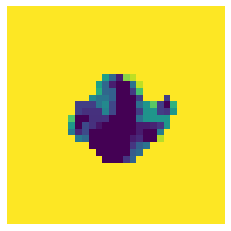

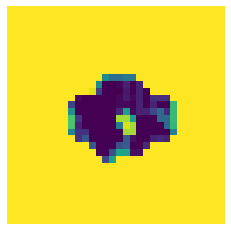

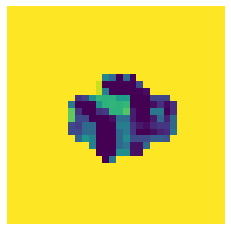

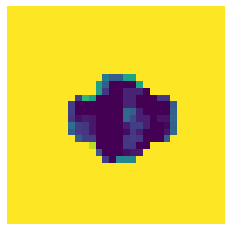

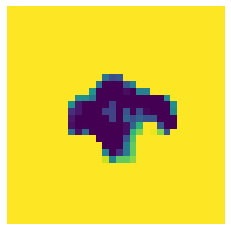

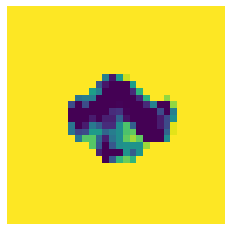

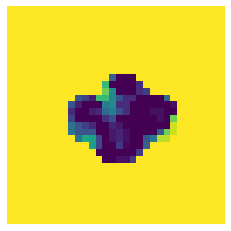

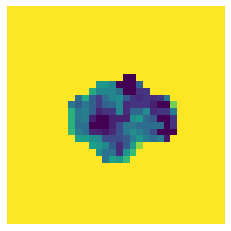

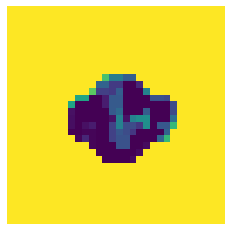

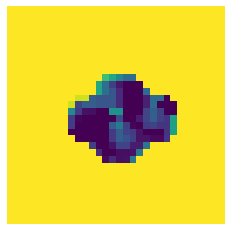

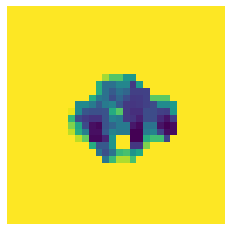

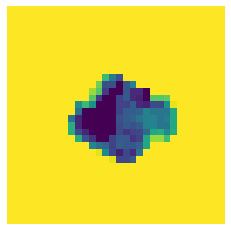

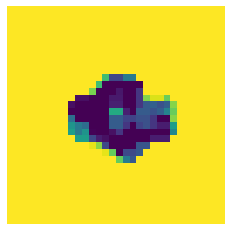

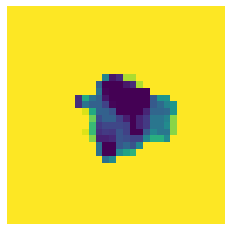

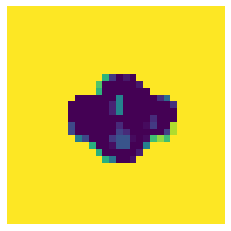

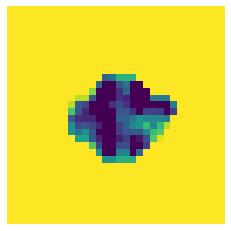

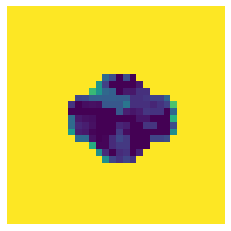

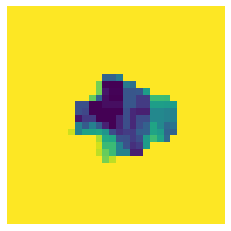

In [103]:
# test_imgset = Imgset(images_mass[:3], [[''],[''],['']], [1, 1, 1], img_loader, bool_square_images=True)
test_imgs = []
test_labels = []
test_imgs.extend(X_test_mass)
test_labels.extend(y_test_mass)
test_imgs.extend(X_test_nf)
test_labels.extend(y_test_nf)

test_imgset = Imgset(test_imgs, [['']] * len(test_imgs), 
                     test_labels, img_loader, bool_square_images=True)
test_loader = DataLoader(dataset=test_imgset, batch_size=1, shuffle=False)

with torch.no_grad():
    for i, data in tqdm_notebook(enumerate(test_loader)):
        #load data
        img_orig = images_mass[i].convert('RGB')
        input_img, mask, label = data
        if device_ids:
            input_img = input_img.cuda(device_ids[0])
        c_label = label.numpy()
        img_name = os.path.splitext(names_mass[i])[0]
        #classify
        output, *_ = model(input_img)
        out = output.cpu().numpy().argmax(-1)[0]
        print(f'Predicted as: {categories[out]}')
#         pred_class = categories_train[out]
#         print('\nImage {} classified as {}'.format(img_name,pred_class))
        #localize occluder
        score, occ_maps, part_scores = net.get_occlusion(input_img, label)
        occ_map = occ_maps[0].detach().cpu().numpy()
        occ_map = cv2.medianBlur(occ_map.astype(np.float32), 3)
        occ_img = visualize_response_map(occ_map, tit='',cbarmax=0)
        # concatenate original image and occluder map
        img_orig = np.array(img_orig)
        faco = img_orig.shape[0] / occ_img.shape[0]
        occ_img_s = cv2.resize(occ_img, (int(occ_img.shape[1] * faco), img_orig.shape[0]))
#         out_name = f'results/2/{img_name}_with_occlusion_map.png'
        canvas = np.concatenate((img_orig, occ_img_s), axis=1)
#         cv2.imwrite(out_name, canvas)